# ESE-2000 Lab 6
TO DO add intro

We download a ~1MB file containing the entirety of Shakespeare's work. This is the dataset we will train our language model on.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from IPython.core.display_functions import clear_output
import matplotlib.pyplot as plt
import math
import wandb
import re
device = "cpu"
if torch.backends.mps.is_available():
    device = "mps:0"
elif torch.cuda.is_available():
    device = "cuda:0" 
print(f"Using device: {device}")

Using device: cuda:0


### Data

###  Data Loading

In [3]:
with open('input.txt') as f:
    text = f.read()
    

print("----Sample Shakespeare----")
print(text[:250])

----Sample Shakespeare----
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## Tokenization

Tokenization converts raw sub-sequences of text (substrings) to sequences of integers. For example, `"ll." -> 208`. We will be developing a character level language model, so we will be converting each individual word into an integer. For example, `"Hello" -> 48`.

In [4]:
def split_to_words(text):
    return re.findall(r"\w+(?:'\w+)?|[.,!?;:\"()\[\]{}<>\\/\-—–…]|\n", text)

vocab = list(set(split_to_words(text)))
c = len(vocab)
print("Number of words: {}".format(len(split_to_words(text))))
print("Number of distinct words in text: {}".format(c))

Number of words: 292072
Number of distinct words in text: 14295


In [5]:
# Use index to map words to integer
stoi = {word:i for i, word in enumerate(vocab)}
itos = {i:word for i, word in enumerate(vocab)}
def words_to_tokens(words):
    return [stoi[w] for w in words]

def tokens_to_words(int_list):
    decoded = " ".join([itos[i] for i in int_list])
    return re.sub(r'\s+([.,!?;:"(){}\[\]<>\\/\-—–…])', r'\1', decoded)

sample_words = text[:36]
print("Original text: {}\n".format(sample_words))
print("Encoded text: {}\n".format(words_to_tokens(split_to_words(sample_words))))
print("Decoded text: {}\n".format(tokens_to_words(words_to_tokens(split_to_words(sample_words)))))

Original text: First Citizen:
Before we proceed any

Encoded text: [213, 12384, 11313, 10436, 12540, 12613, 10482, 7206]

Decoded text: First Citizen: 
 Before we proceed any



In [6]:
tokenized_text = words_to_tokens(split_to_words(text))
print("Encoded text sample: {}".format(tokenized_text[:10]))
print(tokens_to_words(tokenized_text[:10]))
tokenized_text = torch.tensor(tokenized_text)

Encoded text sample: [213, 12384, 11313, 10436, 12540, 12613, 10482, 7206, 12, 4012]
First Citizen: 
 Before we proceed any further,


### Data Split

In [7]:
T = 64 # context size
split_factor = 0.9
split_index = int(split_factor * len(tokenized_text))
train = tokenized_text[:split_index].to(device)
test = tokenized_text[split_index:].to(device)

### Data Loader

In [8]:
class TextDataset(Dataset):
    def __init__(self, text, T):
        self.text = text
        self.T = T
        assert self.T < len(text), "context_size (T) must be less than len(text)"

    def __len__(self):
        return len(self.text) - self.T

    def __getitem__(self, idx):
        X_item = self.text[idx:idx + self.T]
        #Y_item = self.text[idx + 1:idx + self.T + 1]
        # single item 
        Y_item = self.text[idx + self.T]
        return X_item, Y_item

train_set = TextDataset(train, T)
test_set = TextDataset(test, T)


# Example of a batch
B = 4
train_loader = DataLoader(train_set, batch_size=B, shuffle=True)
test_loader = DataLoader(test_set, batch_size=B, shuffle=False)

E, y_idx = next(iter(train_loader))
print(f"X_idx shape: {E.shape}")
print(f"y_idx shape: {y_idx.shape}")

X_idx shape: torch.Size([4, 64])
y_idx shape: torch.Size([4])


## Co-occurrence matrix

In [9]:
#TODO commented bc its slow
# Create co-occurrence matrix
# The co-occurrence matrix C is a c x c (c is our vocab size) symmetric matrix where C_ij is how many times the ith word appears within W words away from the jth word.
# W = 10
# C = torch.stack([torch.zeros(len(vocab)) for _ in range(len(vocab))])
# for t_idx in trange(len(tokenized_text)):
#     left_bound = max(t_idx-W//2,0)
#     right_bound = min(t_idx+W//2+1,len(tokenized_text))
#     context_words = tokenized_text[left_bound : right_bound]
#     for u_idx in range(left_bound, right_bound):
#         t = tokenized_text[t_idx]
#         u = tokenized_text[u_idx]
#         C[t, u] += 1.0
# C = C.to(device)
# # X should be a symmetric matrix
# torch.isclose(C, C.T, atol=1e-3).all()

# # Save C so that we dont have to compute it again
#torch.save(C, "C.pt")

# Load C from storage
C = torch.load("C.pt").to(device)

/tmp/ipykernel_67557/504936921.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  C = torch.load("C.pt").to(device)


In [10]:
# size of C in GB: numel times 4 bytes per float / 1e9 which is GB
C.numel() * 4 / 1e9

0.8173881

In [11]:
torch.isclose(C, C.T, atol=1e-3).all()

tensor(True, device='cuda:0')

## PCA Embeddings

In [12]:
# Torch has a bug on mps devices so this won't work on MacBooks
n = 256
# with torch.no_grad():
#     Z = C - C.mean(dim=0, keepdim=True)
#     Z /= Z.std(dim=0, keepdim=True)
#     cov = (Z @ Z.T)/(Z.shape[0] - 1)
#     L, Q = torch.linalg.eigh(cov)
#     principal_eigv = Q[:, -n:].T

#     # PCA embeddings for training
#     embeddings = Z @ principal_eigv.T # (c, n)
#     # Full embeddings if we need them to visualize
#     # In vector form would be Q.T @ x_n
#     full_embeddings = Z @ Q

# torch.save(embeddings, "embeddings.pt")
# Load embeddings
embeddings = torch.load("embeddings.pt").to(device)

/tmp/ipykernel_67557/2854450157.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("embeddings.pt").to(device)


# Visualize embeddings
Decide if this section goes into the notebook or not

## Average coefficients


In [13]:
# K=14295
# #average_coefficients = full_embeddings.mean(axis=0)
# sample_embeddings = full_embeddings[torch.randint(0,full_embeddings.shape[0],(1000,))]
# # Compute the expectation of the absolute value of the norm of each component.
# average_coefficients = sample_embeddings.norm(p=2,dim=0).cpu().numpy()[::-1]
# data = average_coefficients[:K]

# # Reverse the tensor:
# data = data

# # Normalize by sum?
# #data = data / data.sum()

# plt.figure(figsize=(12, 6))
# plt.title(f"Average Coefficients (k={K})")
# fig= plt.plot(range(K), data,marker='.',linestyle='')


# plt.show()

## Principal eigenvalues

In [14]:
# K=64
# L_plot = L[-K:]/L.sum()
# L_plot,_ = L_plot.sort(descending=True)
# L_plot = L_plot.cpu().numpy()
# plt.figure(figsize=(12, 6))
# plt.title("Principal eigenvalues (k=64)")
# markerline, stemlines, baseline = plt.stem(range(K), L_plot, linefmt='b-', markerfmt='o', basefmt='k-')
# plt.setp(markerline, marker='o', fillstyle='none')


## Co ocurrence matrix

In [15]:
# # Top 10 words
# top_10_words = C.sum(axis=0).sort(descending=True).indices[:10]
# top_10_words = [vocab[i] for i in top_10_words]
# print(top_10_words)

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Remove all the punctations and stop words from the matrix for visualization
# X_viz = C.clone()
# words_to_remove = [",", ":", ".", "the", "I", "to", "and", ";", "of", "you", "my", "a", "?", "!", "in", "that", "And", "not", "-", "is", "me", "be", "it", "with", "your", "for", "his", "have", "this", "thou", "as", "thy", "will", "so", "but", "The", "To", "all", "her", "thee", "by", "are", "our", "do", "we"]
# vocab_to_remove_indices = set(words_to_tokens(words_to_remove))
# idx_to_viz = [i for i, word in enumerate(vocab) if word not in vocab_to_remove_indices]
# X_viz = X_viz[idx_to_viz, :][:, idx_to_viz]

# # top 20 words not including stop words
# top_100_words = C.sum(axis=0).sort(descending=True).indices[:100].cpu().numpy()
# top_100_nostop = [word for word in top_100_words if word not in vocab_to_remove_indices]
# display(f"Top 100 words, excluding punctation and most common stop words: {tokens_to_words(top_100_nostop)}")

# # Create a custom colormap
# cmap = plt.cm.get_cmap('viridis').copy()
# cmap.set_over('green')

# # Plot the image with the custom colormap
# plt.figure(figsize=(10, 10))
# plt.imshow(X_viz.cpu().numpy(), cmap=cmap, vmax=3)

# # Add colorbar with custom settings
# cbar = plt.colorbar(extend='max')
# cbar.set_label('Value')

# plt.title('Co-occurrence Matrix')
# plt.show()
# # Model

# Model

## MultiHeadLayer

In [17]:
class MultiHeadLayer(nn.Module):
    """
    An implementation of the multihead attention layer.
    The difference between AttentionLayer and this class is,
    now Q,K,V are matrices of shape (H, m, n), and the attention matrix B is of shape (H, T, T)
    (one attention feature per head)
    Args:
        m (int): The dimension of the Q and K matrices.
        n (int): The number of features, n is the embedding dimension in our case.
        k (int): The dimension of the W matrix.
        H (int): The number of heads.
    """
    def __init__(self, m, n, H):
        super(MultiHeadLayer, self).__init__()
        self.m = m
        self.H = H

        self.Q = nn.Parameter(torch.empty(H, m, n))
        self.K = nn.Parameter(torch.empty(H, m, n))
        self.V = nn.Parameter(torch.empty(H, m, n))

        self.W = nn.Parameter(torch.empty(n, m))
        
        self.nonlinearity = nn.ReLU()
        self.initialize_parameters()
        
        self.norm1 = nn.LayerNorm(n)
        self.norm2 = nn.LayerNorm(n)
        self.dropout = nn.Dropout(0.2)

    def initialize_parameters(self):
        """
        Initialize the values of the learnable parameter matrices.
        Kaiming uniform is just a type of random initialization, you don't need to 
        worry about it. It is a good default initialization for linear layers.
        """
        nn.init.kaiming_uniform_(self.Q, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.K, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.V, a=math.sqrt(5))

        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, X):
        """
        The forward pass of the multihead attention layer, analogous to the one in the 
        AttentionLayer class. The main difference is that we need to make sure that the 
        matrix multiplications account for the new head dimenison.
        Args:
            X (torch.Tensor): The input sequence.
        Returns:
            X_l (torch.Tensor): The output of the multihead attention layer.
        """
        B, T, n = X.shape  # X: (B, T, n)
        
        # Normalize embedding dim. 
        # We permute because nn.LayerNorm always normalizes the last dimension.
        self.norm1(X.permute(0,2,1)).permute(0,2,1)
        

        # Expand X to include the head dimension
        X_expanded = X.unsqueeze(1)  # (B, 1, n, T)

        # Compute QX, KX, VX for each head
        # The unsqueeze is used to add the head dimension to the matrices,
        # because they are of shape (H, m, n), and we need to multiply them
        # with X_expanded of shape (B, 1, n, T)
        QX = torch.matmul(self.Q.unsqueeze(0), X_expanded)  # (B, H, m, T)
        KX = torch.matmul(self.K.unsqueeze(0), X_expanded)  # (B, H, m, T)
        VX = torch.matmul(self.V.unsqueeze(0), X_expanded)  # (B, H, m, T)

        # Transpose QX for multiplication
        
        QX_t = QX.transpose(-2, -1)  # (B, H, T, m)

        # Compute attention scores B per head
        B_matrix = torch.matmul(QX_t, KX)  # (B, H, T, T)

        # Compute attention weights A per head
        A = F.softmax(B_matrix, dim=-1)  # (B, H, T, T)

        # Compute Z per head
        Z = torch.matmul(VX, A)  # (B, H, m, T)

        # Average over the heads
        Z = Z.sum(dim=1)

        # Continue with feed-forward network
        Y_l = torch.matmul(self.W, Z)  # (B, n, T)
        
        # Normalize embedding dim. 
        # We permute because nn.LayerNorm always normalizes the last dimension.
        Y_l = self.norm2(Y_l.permute(0,2,1)).permute(0,2,1)
        
        X_l = X + self.nonlinearity(Y_l)  # (B, n, T)
        
        # Dropout for regularization
        X_l = self.dropout(X_l)

        return X_l
# Test
E = next(iter(train_loader))[0]
B, T = E.shape
E = E.reshape(-1)
X = embeddings[E]
X = X.reshape(B, -1 ,T)
display(f"E shape: {E.shape}")
display(f"embeddings shape: {embeddings.shape}")
print(f"X_idx shape: {X.shape}")
model = MultiHeadLayer(m=3, n=256, H=2).to(device)
out = model(X)
print(f"out shape: {out.shape}") #(B,T,n)

'E shape: torch.Size([256])'

'embeddings shape: torch.Size([14295, 256])'

X_idx shape: torch.Size([4, 256, 64])
out shape: torch.Size([4, 256, 64])


## LLM (todo rename)

In [18]:
class LLM(nn.Module):
    def __init__(self, L, m, H):
        super(LLM, self).__init__()
        self.num_blocks = L
        self.position_embedding = nn.Embedding(T, n) #TO DO replace by actual positional embeddings?
        self.token_embedding = embeddings
        self.decoder_layers = nn.Sequential(*[MultiHeadLayer(m, n, H) for _ in range(L)])
        self.norm = nn.LayerNorm(n)
        self.readout = nn.Parameter(torch.empty(n, c))
        self.initialize_parameters()
    
    def initialize_parameters(self):
        nn.init.kaiming_uniform_(self.readout, a=math.sqrt(5))

    def forward(self, tokens):
        token_emb = self.token_embedding[tokens]
        #token_emb = tokens
        pos_emb = self.position_embedding(torch.arange(tokens.shape[1], device=device))
        x = token_emb + pos_emb
        # We permute to get shape of batch (B) x embed_dim (n) x context_size (T): (B, n, T)
        x = x.permute(0,2,1)
        x = self.decoder_layers(x)
        # Average over the context size
        y_hat = torch.matmul(x.mean(dim=-1), self.readout)
        return y_hat

E = next(iter(train_loader))[0]
model = LLM(L=3, m=3, H=2).to(device)
logits = model(E)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Output shape: {out.shape}") #(B,T,n)
#print(f"Output sample: {out[0,0:1,:]}")
print("logits: ", (logits.argmax(dim=-1).tolist()))
print("text prediction: ", tokens_to_words(logits.argmax(dim=-1).tolist()))



Number of parameters: 3695616
Output shape: torch.Size([4, 256, 64])
logits:  [12066, 5139, 5139, 5139]
text prediction:  tents hid hid hid


## Text Generation Function

In [19]:
def generate(model, input_tokens, max_generate_tokens=500):
    """
    Generate text from a model given an initial input token sequence.
    Args:
        model (nn.Module): The model to use for generation.
        input_tokens (torch.Tensor): The initial input token sequence.
        max_generate_tokens (int): The maximum number of tokens to generate.
    Returns:
        torch.Tensor: The generated token sequence.
    """
    with torch.no_grad():
        generated_sequence = input_tokens.clone()
        for _ in range(max_generate_tokens):
            logits = model(input_tokens)
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated_sequence = torch.cat([generated_sequence, next_token], dim=1)
        generated_words = tokens_to_words(generated_sequence.reshape(-1).tolist())
        generation_string = "".join(generated_words)
        return generation_string

Even with a good chunk of context, the generated text is gibberish at initialization

In [20]:
# Testing code generation method on 
initial = test[132:132+T].unsqueeze(0)
with torch.no_grad():
    generated_words = generate(model,initial, max_generate_tokens=25)
    print("\n===INPUT===\n")
    print(tokens_to_words(initial.reshape(-1).tolist()))
    print("\n===GENERATED TEXT===\n")
    print("".join(generated_words[:]))


===INPUT===

mountains are for winds, 
 That shake not, though they blow perpetually. 
 
 BAPTISTA: 
 How now, my friend! why dost thou look so pale? 
 
 HORTENSIO: 
 For fear, I promise you, if I look pale. 
 
 BAPTISTA: 
 What, will my daughter prove a good musician

===GENERATED TEXT===

mountains are for winds, 
 That shake not, though they blow perpetually. 
 
 BAPTISTA: 
 How now, my friend! why dost thou look so pale? 
 
 HORTENSIO: 
 For fear, I promise you, if I look pale. 
 
 BAPTISTA: 
 What, will my daughter prove a good musician bewept divided can't rued festering age revels jump corrupting Patrician Shalt Peering general's Receive lessons brinish do't began prosperity aloof lighter devices valour viewing whipt


## Train (dev)

In [21]:
E,Y = next(iter(train_loader))
B, T = E.shape
logits = model(E)
print(f"E.shape: {E.shape}")
print(f"Y.shape: {Y.shape}")
print(f"logits.shape: {logits.shape}")
# reshaped 
F.cross_entropy(logits, Y)

E.shape: torch.Size([4, 64])
Y.shape: torch.Size([4])
logits.shape: torch.Size([4, 14295])


tensor(9.5353, device='cuda:0', grad_fn=<NllLossBackward0>)

In [22]:
model.position_embedding.weight.data.numel()
#model.token_embedding.weight.data.numel()
model.decoder_layers[0].Q.data.numel()

1536

In [23]:
L = 3
H = 8
#m = n//H
m = 32
lr = 1e-4
num_epochs = 5
#num_epochs = 1

model = LLM(L, m, H).to(device)
num_parameters_str = str(sum(p.numel() for p in model.parameters())/1e6,) + 'M parameters'
print("Created new model with {}".format(num_parameters_str))
run = wandb.init(
    project="lab-9-llm",
    entity="ese-2000",
    config={
        "architecture": "Transformer",
        "dataset": "TinyShakespeare",
        "num_epochs": num_epochs,
        "learning_rate": lr,
        "num_blocks": L,
        "num_heads_per_block": H,
        "context_size": T,
        "m": m,
        "n": n,
        "model_summary": str(model),
        "num_parameters": num_parameters_str
    }
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Created new model with 4.293888M parameters


wandb: Currently logged in as: javierporras (ese-2000). Use `wandb login --relogin` to force relogin


Epoch 20, Loss 4.913678296748095


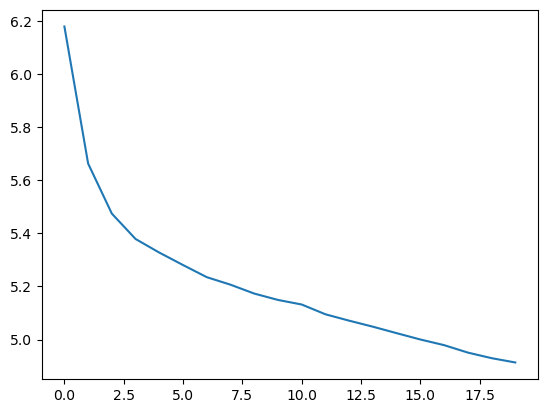

epoch_train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_loss,▄▄▂▄▅▂▃▂▃▆█▄▁▅▅▄▂▄▃▄▁▄▅▄▃▃▃▅▃▄▂▃▄▄▁▃▄▃▃▃
epoch_train_loss,4.91368
train_loss,2.57532


In [105]:
from tqdm import trange, tqdm

opt = optim.AdamW(model.parameters(), lr=lr)
model.train()

train_loss_evolution = []
for epoch in range(num_epochs):
    train_loss = 0
    for x, y in tqdm(train_loader):
        logits = model(x)
        B, _ = logits.shape
        #loss = F.cross_entropy(logits.reshape(B * T, -1), y.reshape(B * T, -1).squeeze())
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
        wandb.log({"train_loss": loss.item()})
    train_loss_evolution.append(train_loss/len(train_loader))
    clear_output()
    print(f"Epoch {epoch+1}, Loss {train_loss/len(train_loader)}")
    run.log({"epoch_train_loss": train_loss/len(train_loader)},commit=False)
    wandb.config.update({"num_epochs": epoch+1})
    plt.plot(train_loss_evolution)
    plt.show()
# torch.save(model, "./model.pt")
# wandb.save('./model.pt')

# Testing code generation
initial = test[132:132+T].unsqueeze(0)
generated_text = generate(model,initial, max_generate_tokens=100)
print("\n===INPUT===\n")
print(tokens_to_words(initial.reshape(-1).tolist()))
print("\n===GENERATED TEXT===\n")
print("".join(generated_text[:]))

#finish run
run.finish()


## Train (actual loop)

In [14]:

# if os.path.exists("./model.pt"):
#     model = torch.load("./model.pt", map_location=device)
#     print("Loaded existing model")
# else:
#     L = 1
#     H = 2
#     m = n//H
#     model = LLM(L, m, H).to(device)
#     lr = 1e-4
#     opt = optim.AdamW(model.parameters(), lr=lr)
#     #num_epochs = 20
#     num_epochs = 1
#     model.eval()
#     num_parameters_str = str(sum(p.numel() for p in model.parameters())/1e6,) + 'M parameters'
#     # wandb.config.update({"lr": lr, 
#     #                     "num_blocks": num_blocks, 
#     #                     "num_heads_per_block": num_heads_per_block,
#     #                     "context_size": T,
#     #                     "num_epochs": num_epochs,
#     #                     "model_summary": str(model),
#     #                     "num_parameters": num_parameters_str})
#     print("Created new model with {}".format(num_parameters_str))
#     train_loss_evolution = []
#     for epoch in trange(num_epochs):
#         train_loss = 0
#         for t_idx, (x, y) in enumerate(train_loader):
#             logits = model(x)
#             batch_size, _, _ = logits.shape
#             #loss = F.cross_entropy(logits.view(batch_size * T, -1), y.view(batch_size * T, -1).squeeze())
#             loss = F.cross_entropy(logits, y)
#             opt.zero_grad()
#             loss.backward()
#             opt.step()
#             train_loss += loss.item()
#         train_loss_evolution.append(train_loss/len(train_loader))
#         clear_output()
#         print(f"Epoch {epoch+1}, Loss {train_loss/len(train_loader)}")
#         run.log({"epoch_train_loss": train_loss/len(train_loader)}) 
#         wandb.config.update({"num_epochs": epoch+1})
#         plt.plot(train_loss_evolution)
#         plt.show()
#     torch.save(model, "./model.pt")
#     wandb.save('./model.pt')
    

Created new model with 0.247296M parameters


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [56,0,0], thread: [32,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [56,0,0], thread: [34,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [56,0,0], thread: [35,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [56,0,0], thread: [36,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [56,0,0], thread: [37,0,0] Assertion `t >= 0 && t

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
test_loss = 0
with torch.no_grad():
    for t_idx, (x, y) in enumerate(test_loader):
        logits = model(x)
        B, _ = logits.shape
        loss = F.cross_entropy(logits, y)
        test_loss += loss.item()

print("Test loss: ", test_loss / len(test_loader))

Test loss:  7.485606698046796


In [1]:
initial = test[132:132+T].unsqueeze(0)
generated_text = generate(model,initial, max_generate_tokens=100)
print("\n===INPUT===\n")
print(tokens_to_words(initial.reshape(-1).tolist()))
print("\n===GENERATED TEXT===\n")
print("".join(generated_text[:]))

NameError: name 'test' is not defined

In [21]:
torch.release